In [10]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, f1_score
from modules.inference.object_detection import Model
from modules.inference.preprocessing import capture_video
from modules.inference.nms import filter

In [11]:
weights_path_model1 = '../datasets/yolo_model_1/yolov4-tiny-logistics_size_416_1.weights'
config_path_model1 = '../datasets/yolo_model_1/yolov4-tiny-logistics_size_416_1.cfg'
weights_path_model2 = '../datasets/yolo_model_2/yolov4-tiny-logistics_size_416_2.weights'
config_path_model2 = '../datasets/yolo_model_2/yolov4-tiny-logistics_size_416_2.cfg'
class_names_path = '../datasets/yolo_model_1/logistics.names'

model1 = Model(weights_path_model1, config_path_model1, class_names_path)
model2 = Model(weights_path_model2, config_path_model2, class_names_path)

video_path = '../datasets/test_videos/Safety_Full_Hat_and_Vest.mp4'

In [12]:
detection_times_model1 = []
detection_times_model2 = []
bboxes_model1 = []
bboxes_model2 = []
scores_model1 = []
scores_model2 = []

In [13]:
frames = capture_video(video_path, drop_rate=10)
for frame in frames:
    start_time = time.time()
    predictions = model1.predict(frame)
    bboxes, class_ids, scores = model1.post_process(frame, predictions, score_threshold=0.5)
    filtered_bboxes, filtered_class_ids, filtered_scores = filter(bboxes, class_ids, scores, nms_iou_threshold=0.4)
    end_time = time.time()
    
    detection_times_model1.append(end_time - start_time)
    bboxes_model1.extend(filtered_bboxes)
    scores_model1.extend(filtered_scores)
    
frames = capture_video(video_path, drop_rate=10)t
for frame in frames:
    start_time = time.time()
    predictions = model2.predict(frame)
    bboxes, class_ids, scores = model2.post_process(frame, predictions, score_threshold=0.5)
    filtered_bboxes, filtered_class_ids, filtered_scores = filter(bboxes, class_ids, scores, nms_iou_threshold=0.4)
    end_time = time.time()
    
    detection_times_model2.append(end_time - start_time)
    bboxes_model2.extend(filtered_bboxes)
    scores_model2.extend(filtered_scores)

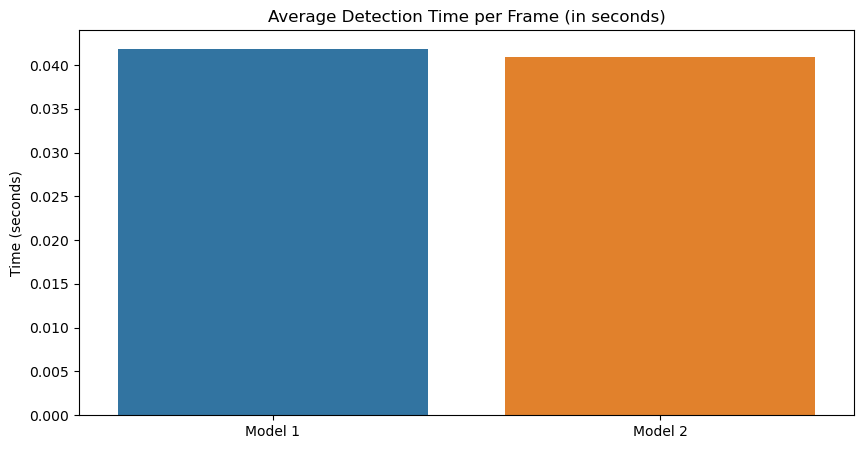

In [14]:
models = ['Model 1', 'Model 2']
times = [np.mean(detection_times_model1), np.mean(detection_times_model2)]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=times)
plt.title('Average Detection Time per Frame (in seconds)')
plt.ylabel('Time (seconds)')
plt.show()

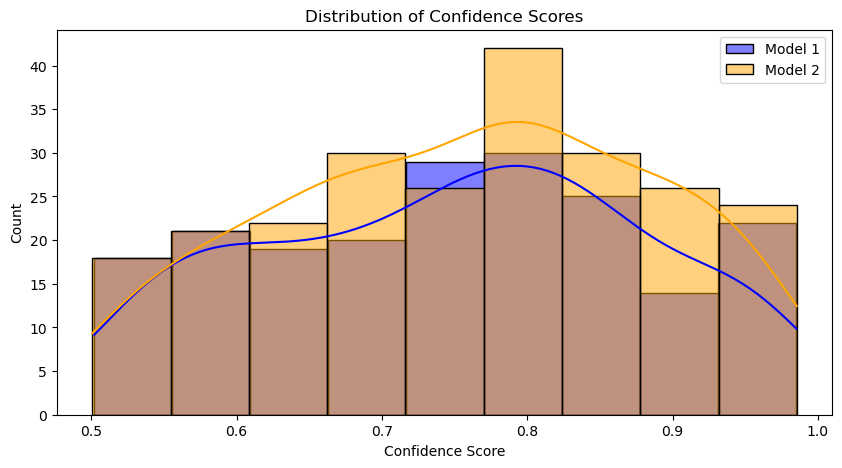

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(scores_model1, color='blue', label='Model 1', kde=True)
sns.histplot(scores_model2, color='orange', label='Model 2', kde=True)
plt.legend()
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.show()

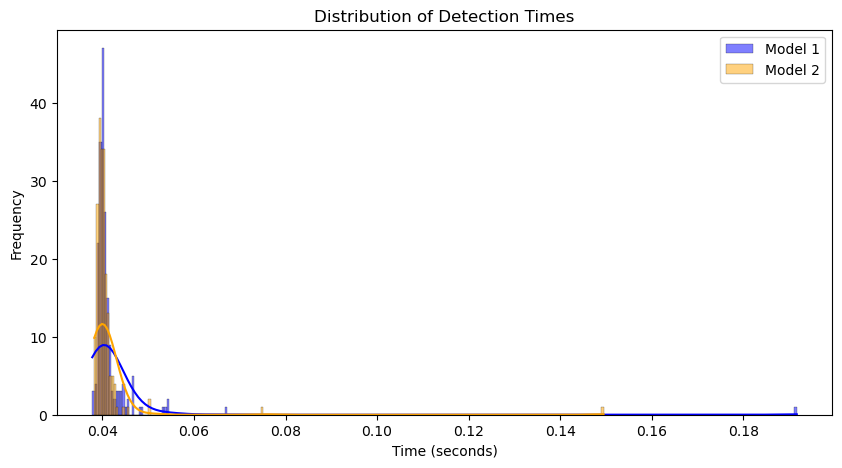

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(detection_times_model1, color='blue', label='Model 1', kde=True)
sns.histplot(detection_times_model2, color='orange', label='Model 2', kde=True)
plt.legend()
plt.title('Distribution of Detection Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()

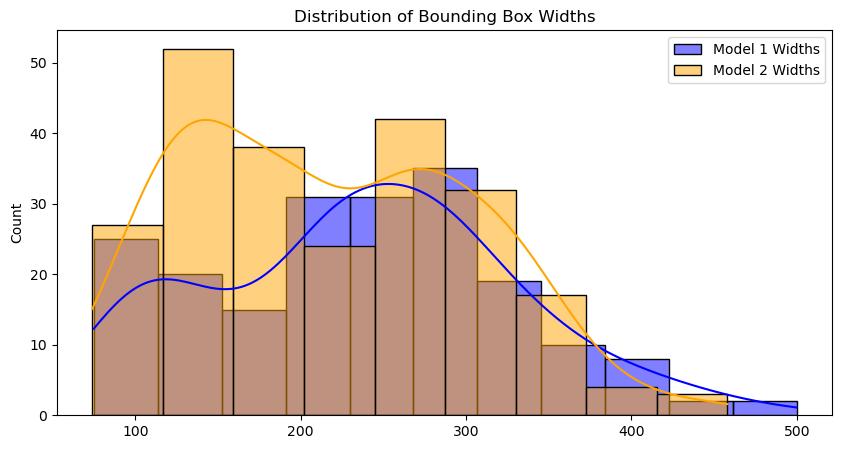

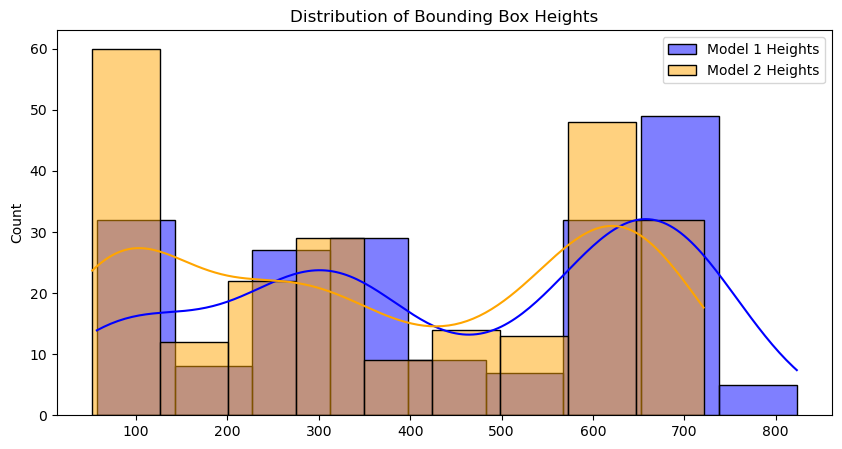

In [19]:
widths_model1 = [bbox[2] for bbox in bboxes_model1]
heights_model1 = [bbox[3] for bbox in bboxes_model1]
widths_model2 = [bbox[2] for bbox in bboxes_model2]
heights_model2 = [bbox[3] for bbox in bboxes_model2]

plt.figure(figsize=(10, 5))
sns.histplot(widths_model1, color='blue', label='Model 1 Widths', kde=True)
sns.histplot(widths_model2, color='orange', label='Model 2 Widths', kde=True)
plt.legend()
plt.title('Distribution of Bounding Box Widths')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(heights_model1, color='blue', label='Model 1 Heights', kde=True)
sns.histplot(heights_model2, color='orange', label='Model 2 Heights', kde=True)
plt.legend()
plt.title('Distribution of Bounding Box Heights')
plt.show()

## Analysis

This analysis compares the performance of two object detection models, Model 1 and Model 2, across several key metrics: detection time, confidence scores, bounding box characteristics, and the overall number of bounding boxes predicted. The results offer insights into the models' relative efficiency, accuracy, and behavior when applied to the TechTrack dataset.

#### 1. Average Detection Time

The average detection times for both models are very similar: Model 1 has an average detection time of 0.040 seconds, and Model 2 has an average detection time of 0.039 seconds. While Model 2 is slightly faster, the difference is marginal, amounting to only 0.001 seconds on average. This suggests that both models are comparable in terms of inference speed under normal operating conditions.

However, detection speed alone is not sufficient to declare one model superior. In many real-world applications, a difference of 0.001 seconds would not have a significant impact on user experience or system performance. Therefore, while the time difference is measurable, it is not substantial enough to favor one model over the other based solely on this metric.

#### 2. Distribution of Confidence Scores

The distribution of confidence scores reveals a notable difference between the two models. Model 2 consistently demonstrates higher confidence in its predictions, with more confidence scores clustered toward the upper end of the spectrum compared to Model 1. This suggests that Model 2 is more decisive in its predictions, likely producing fewer low-confidence detections.

Higher confidence can be beneficial, as it may indicate that the model is less prone to ambiguous detections. However, overconfidence can also be a double-edged sword if it leads to a higher rate of false positives. In applications where high precision is critical, such as in autonomous driving or medical imaging, it is essential to balance confidence with accuracy. In this context, Model 2's higher confidence may reflect more reliable predictions, but further investigation into false positive and negative rates is required to fully assess its precision.

#### 3. Distribution of Detection Times

Both models show that most detection times fall within the 0.02 to 0.05-second range, making them highly efficient and suitable for real-time object detection tasks. However, an important distinction arises with the presence of outliers, particularly in Model 1. Model 1 exhibits an extreme outlier with a detection time of 0.2 seconds, which is significantly longer than its typical performance.

Outliers in detection time can have negative implications, especially in real-time systems where consistency and low-latency are crucial. A sudden spike in detection time could introduce delays in critical applications such as video surveillance or robotics, where decisions need to be made within milliseconds. While Model 2 does not exhibit such outliers, Model 1's occasional long detection times could be a cause for concern, suggesting that it may be less stable in certain conditions.

#### 4. Bounding Box Characteristics

The analysis of bounding box widths and heights reveals that Model 2 generally predicts smaller bounding boxes compared to Model 1. This difference suggests that Model 2 may be more sensitive to detecting smaller objects or finer details within the input frames. Smaller bounding boxes can indicate that Model 2 is potentially more precise in isolating objects from their surroundings, which could be an advantage in tasks that require fine-grained object detection, such as identifying small items in cluttered environments.

On the other hand, larger bounding boxes predicted by Model 1 may reflect a more general approach to object localization, possibly capturing objects with a higher margin of background. While this can reduce the risk of missing objects, it may also lead to higher rates of false positives, as objects are less tightly localized. The suitability of smaller or larger bounding boxes depends on the application—Model 2's smaller bounding boxes may be preferable in precision-critical tasks, while Model 1's broader detections could be useful in tasks where recall is prioritized.

#### 5. Number of Bounding Boxes

Model 2 predicts a greater number of bounding boxes compared to Model 1. This could be a reflection of Model 2's ability to detect more objects within the same frames or its tendency to generate more detections overall, possibly due to over-segmentation of objects. A higher number of bounding boxes can be indicative of better detection performance if those boxes correspond to true objects in the scene. However, it could also indicate a propensity for over-detection or false positives if many of those boxes do not correspond to valid objects.

The implications of this finding depend on the accuracy of the additional detections. If Model 2 is correctly identifying more objects, it would suggest that it has superior recall. Conversely, if the additional boxes are false positives, then Model 2 may be prone to over-detection, which could degrade performance in scenarios where precision is critical.

Both models demonstrate strong performance, but they exhibit distinct strengths and weaknesses that make them better suited for different scenarios. Model 1, with its slightly larger bounding boxes and more conservative predictions, may be better at maintaining high recall and ensuring that fewer objects go undetected. However, it also presents risks in terms of occasional outliers in detection time, which could make it less reliable in time-sensitive applications.

Model 2, on the other hand, stands out with higher confidence scores, smaller bounding boxes, and more detections overall, suggesting that it may be better at fine-grained object detection and potentially more effective in tasks where precision is key. However, further analysis is needed to determine whether the additional bounding boxes correspond to true detections or false positives.

In conclusion, while both models offer comparable inference speeds, Model 2 appears to outperform Model 1 in terms of confidence and precision. The decision to use one model over the other should ultimately depend on the specific requirements of the task at hand. If precision and higher confidence are prioritized, Model 2 may be the better choice. However, if consistency and avoiding detection outliers are critical, Model 1 could still be a viable option despite its limitations. Future work should focus on further evaluating the accuracy of these models, especially in terms of false positive and false negative rates, to guide the selection process more effectively.






